In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from rich.console import Console
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import json
from pathlib import Path


In [2]:
def smart_formatter(x, pos):
    if x >= 1e12:
        return f'{x/1e12:.1f}T'
    if x >= 1e9:
        return f'{x/1e9:.1f}B'
    if x >= 1e6:
        return f'{x/1e6:.0f}M'
    if x >= 1e3:
        return f'{x/1e3:.1f}K'
    return f'{x:.0f}'


/tmp/ipykernel_3166202/2446824053.py:41: RuntimeWarning: divide by zero encountered in power
  y_pred = a * np.power(x_pred, b)


Training speed: 10,639 tokens/second
Training speed: 38,299,191 tokens/hour
Training speed: 919,180,578 tokens/day
Tokens needed for chinchilla: -391,720,960
Time needed for chinchilla: -0.4 days


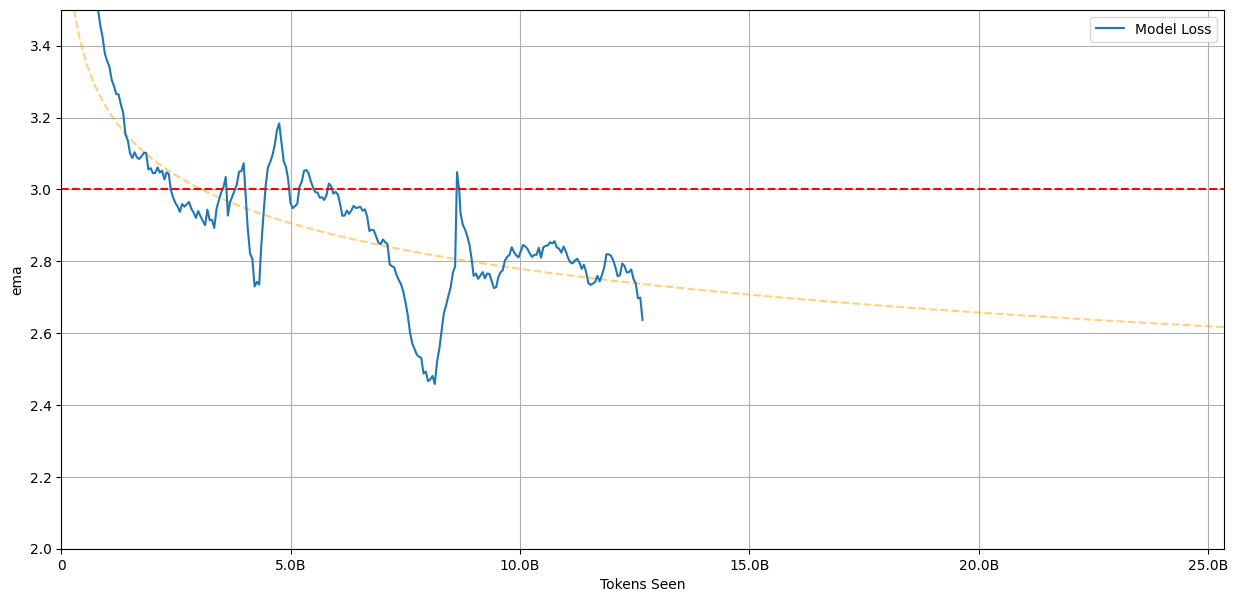

In [3]:
df = pd.read_json('models/flicker/training.jsonl', lines=True)


# down-sample df

pct = 0.01
n = int(1 / pct)
df = df.iloc[::n]


df["ema"] = df["loss"].ewm(span=5).mean()


x_label = 'tokens_seen'

# end = 1.4e12
parameters = 613_860_352

tokens_seen = df[x_label].max()
end = 2 * 11e9 # billions
end = tokens_seen * 2


start_tokens = 1e9

# Filter to only use data after the offset
reg_df = df[df[x_label] >= start_tokens]

# Fit on the filtered data
X_log = np.log(reg_df[x_label].values).reshape(-1, 1)
y_log = np.log(reg_df['ema'].values)


model = LinearRegression()
model.fit(X_log, y_log)

# Extract power-law parameters
b = model.coef_[0]  # exponent
a = np.exp(model.intercept_)  # coefficient
x_pred = np.linspace(0, end, 1000)
y_pred = a * np.power(x_pred, b)




# --------------------------
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.lineplot(x=x_pred, y=y_pred, linestyle='--', color='orange', alpha=0.5)

g = sns.lineplot(df, x=x_label, y='ema', label="Model Loss")
g.axhline(3, color='red', linestyle='--', alpha=1)
# g.axhline(df['ema'].min(), color='blue', linestyle='--', alpha=1)

g.set_xlabel('Tokens Seen')

g.xaxis.set_major_formatter(ticker.FuncFormatter(smart_formatter))

g.set_ylim(2., 3.5) # df['ema'].max())
g.set_xlim(0, end)
g.grid()

# ---------------------------


# filter df where 'datetime' is not null
df = df[df['datetime'].notnull()]
# Convert datetime to actual datetime objects if they're strings
df['datetime'] = pd.to_datetime(df['datetime'])
df['elapsed_seconds'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds()
tokens_per_second = df[x_label].iloc[-1] / df['elapsed_seconds'].iloc[-1]

print(f"Training speed: {tokens_per_second:,.0f} tokens/second")
print(f"Training speed: {tokens_per_second * 3600:,.0f} tokens/hour")
print(f"Training speed: {tokens_per_second * 3600 * 24:,.0f} tokens/day")



tokens_needed_for_chinchilla = parameters * 20 - tokens_seen
time_for_chinchilla = tokens_needed_for_chinchilla / tokens_per_second
print(f"Tokens needed for chinchilla: {tokens_needed_for_chinchilla:,.0f}")
print(f"Time needed for chinchilla: {time_for_chinchilla / 3600 / 24:.1f} days")

<Axes: xlabel='tokens_seen', ylabel='lr'>

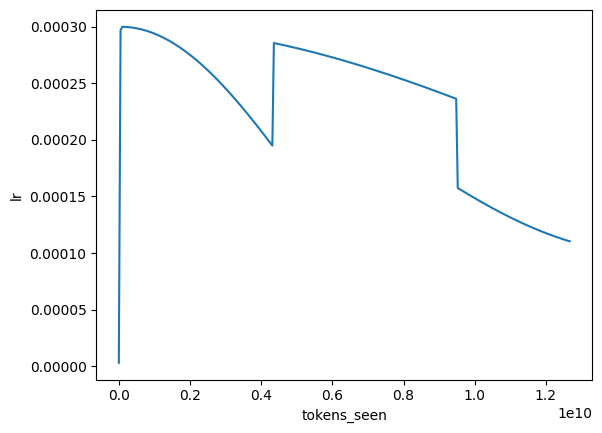

In [4]:
sns.lineplot(df, x='tokens_seen', y='lr')

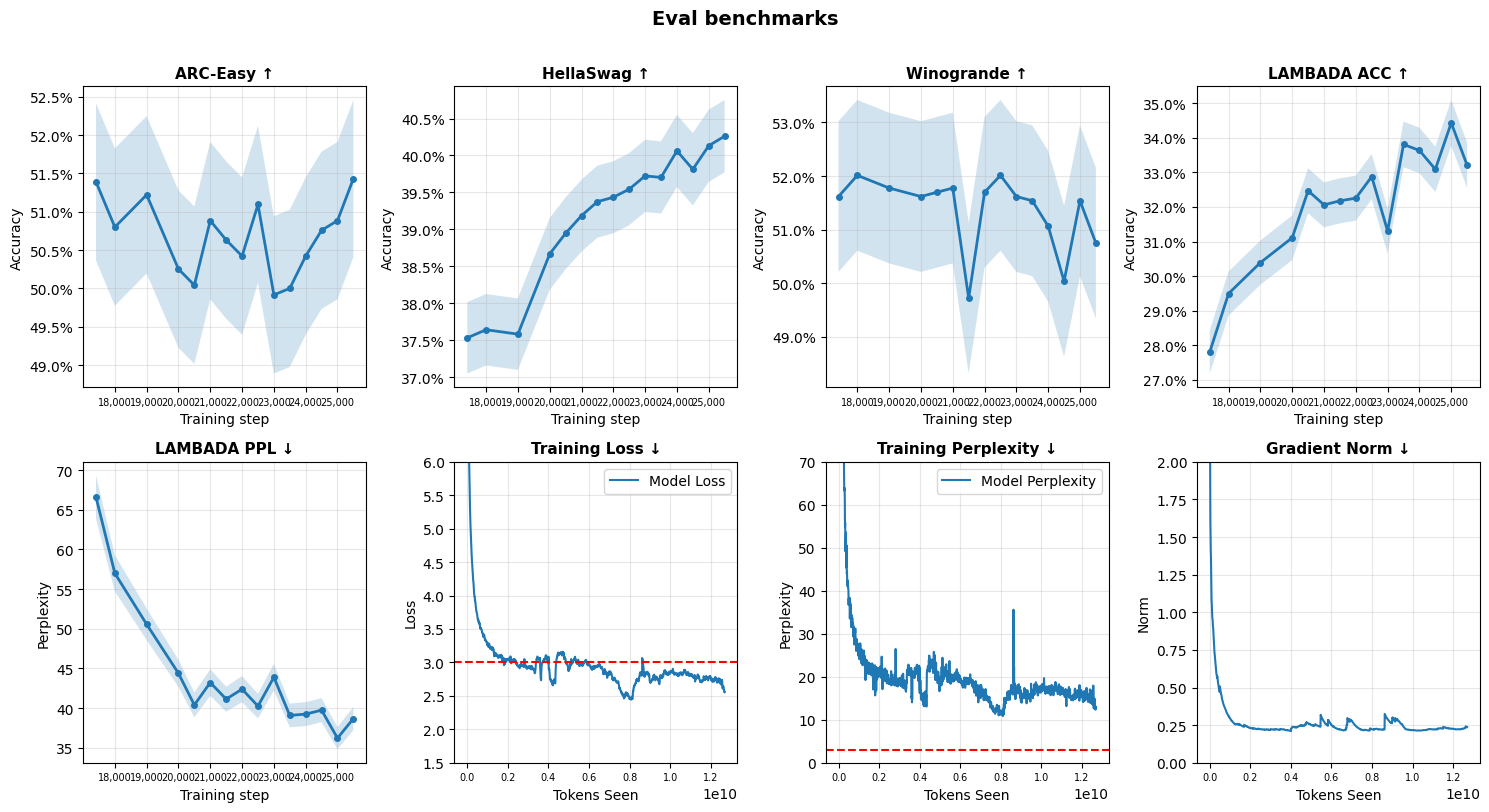

In [14]:
EVAL_FILE = "models/flicker/evaluation.jsonl"  # change to your path

# ── Load ──────────────────────────────────────────────────────────────────────
records = []
with open(EVAL_FILE) as f:
    for line in f:
        records.append(json.loads(line))
records.sort(key=lambda r: r["step"])

steps = np.array([r["step"] for r in records])

def col(task, key):
    return np.array([r["results"][task][key] for r in records])

def err(task, key):
    return np.array([r["results"][task][key] for r in records])

# ── Metric definitions ────────────────────────────────────────────────────────
# (task, metric_key, stderr_key, display_name, higher_is_better)
metrics = [
    ("arc_easy",       "acc_norm,none",      "acc_norm_stderr,none",       "ARC-Easy",        "Accuracy",      True),
    ("hellaswag",      "acc_norm,none",      "acc_norm_stderr,none",       "HellaSwag",       "Accuracy",      True),
    ("winogrande",     "acc,none",           "acc_stderr,none",            "Winogrande",      "Accuracy",      True),
    ("lambada_openai", "acc,none",           "acc_stderr,none",            "LAMBADA ACC",     "Accuracy",      True),
    ("lambada_openai", "perplexity,none",    "perplexity_stderr,none",     "LAMBADA PPL",     "Perplexity",    False),
]

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

CHANCE = {"ARC-Easy  acc_norm": 0.25, "HellaSwag acc_norm": 0.25,
          "Winogrande acc": 0.50,     "LAMBADA acc": None}

for ax, (task, key, skey, name, ylabel, higher) in zip(axes, metrics):
    y  = col(task, key)
    se = err(task, skey)

    ax.plot(steps, y, lw=2, marker='o', markersize=4)
    ax.fill_between(steps, y - se, y + se, alpha=0.2)

    # chance-level reference line
    chance = CHANCE.get(name)
    if chance is not None:
        ax.axhline(chance, color='gray', lw=1, ls='--', label=f'chance ({chance})')
        ax.legend(fontsize=8)

    title = f'{name} ↑' if higher else f'{name} ↓'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel("Training step")
    ax.set_ylabel(ylabel)

    # if the y axis is "Accuracy", convert to %.
    if ylabel == "Accuracy":
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{(x * 100):4.1f}%"))
        # ax.set_ylim(0, 1)


    # x-axis: show token count as secondary label
    def step_to_tokens(s):
        return f"{s/1000:.0f}k\n({s*0.5:.0f}M tok)"
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.tick_params(axis='x', labelsize=7)
    ax.grid(True, alpha=0.3)


# Plot loss on the last axis

df = pd.read_json('models/flicker/training.jsonl', lines=True)
pct = 0.05
n = int(1 / pct)
df = df.iloc[::n]
ax = axes[5]

df["ema"] = df["loss"].ewm(span=5).mean()
g = sns.lineplot(df, x='tokens_seen', y='ema', label="Model Loss", ax=ax)
g.axhline(3, color='red', linestyle='--', alpha=1)

ax.tick_params(axis='x', labelsize=7)
ax.grid(True, alpha=0.3)
ax.set_ylim(1.5, 6)
ax.set_title("Training Loss ↓", fontsize=11, fontweight='bold')
ax.set_ylabel("Loss")
ax.set_xlabel("Tokens Seen")



ax = axes[6]
g = sns.lineplot(df, x='tokens_seen', y='perplexity', label="Model Perplexity", ax=ax)
g.axhline(3, color='red', linestyle='--', alpha=1)

ax.tick_params(axis='x', labelsize=7)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 70)
ax.set_title("Training Perplexity ↓", fontsize=11, fontweight='bold')
ax.set_ylabel("Perplexity")
ax.set_xlabel("Tokens Seen")


ax = axes[7]
df["norm_ema"] = df["norm"].ewm(span=50).mean()
g = sns.lineplot(df, x='tokens_seen', y='norm_ema', ax=ax)

ax.tick_params(axis='x', labelsize=7)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 2)
ax.set_title("Gradient Norm ↓", fontsize=11, fontweight='bold')
ax.set_ylabel("Norm")
ax.set_xlabel("Tokens Seen")


# # hide unused subplot
# axes[-1].set_visible(False)


fig.suptitle("Eval benchmarks", fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("training_progress.png", dpi=300, bbox_inches='tight')
plt.show()